In [1]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import ImageGrid
from dotenv import load_dotenv

import os
import glob
import pandas as pd
import json

from db_tools import get_db, filter_df, make_animation, get_data, metrics_grid

In [ ]:
def compute_classification_metrics(
    df, start_frame=0, end_frame=-1
) -> pd.DataFrame:
    """
    Compute classification metrics for a given range of frames.
    """
    # Filter the dataframe to only include the relevant frames
    if len(df) == 0:
        return None

    for i, row in df.iterrows():
        num_snapshots = row["n_snapshots"]
        assert start_frame < num_snapshots, "start_frame must be less than num_snapshots"
        if end_frame == -1:
            end_frame = num_snapshots
        
        ds = nc.Dataset(row["filename"])
        data = ds.variables["data"][:]  # Assume shape [time, spatial, ...]
        steady_state = np.zeros_like(data[0, 0, :, :])
        steady_state[:, 0::2] = row["A"]  # u = A
        steady_state[:, 1::2] = row["B"] / row["A"]  # v = B / A

        deviations = []
        time_derivatives = []

        du_dt = np.gradient(
            data[0, :, :, :], row["dt"], axis=0
        )  # Time derivative of (u, v)

        for j in range(start_frame, min(end_frame, num_snapshots)):
            deviations.append(np.linalg.norm(data[0, j, :, :] - steady_state))
            time_derivatives.append(np.linalg.norm(du_dt[j]))

        final_dev = deviations[-1]
        mean_dev = np.mean(deviations)
        std_dev = np.std(time_derivatives)
        max_derivative = np.max(time_derivatives)
        df.loc[i, "final_deviation"] = final_dev
        df.loc[i, "mean_deviation"] = mean_dev
        df.loc[i, "std_deviation"] = std_dev
        df.loc[i, "max_derivative"] = max_derivative
        ds.close()
    return df

In [2]:
def classify_trajectories(
    df,
    start_frame,
    steady_threshold=1e-3,
    osc_threshold=1e-2,
    dev_threshold=1e-2,
) -> pd.DataFrame:
    """
    Classify runs based on behavior: inserts column 'category' into DataFrame.
    Possible categories: 'steady_state', 'interesting', 'divergent_or_unknown'.
    Args:
        df: DataFrame containing run metadata.
        steady_threshold: Threshold for ||du/dt|| to classify as steady.
        osc_threshold: Threshold for oscillatory behavior.
        dev_threshold: Threshold for deviation from the steady state.

    Returns:
        Updated DataFrame with classification labels.
    """

    if len(df) == 0:
        return None

    classifications = []
    for i, row in df.iterrows():
        Nt = row["n_snapshots"]
        assert start_frame < Nt, "start_frame must be less than Nt"

        ds = nc.Dataset(row["filename"])
        data = ds.variables["data"][:]  # Assume shape [time, spatial, ...]
        steady_state = np.zeros_like(data[0, 0, :, :])
        steady_state[:, 0::2] = row["A"]  # u = A
        steady_state[:, 1::2] = row["B"] / row["A"]  # v = B / A

        deviations = []
        time_derivatives = []

        du_dt = np.gradient(
            data[0, :, :, :], row["dt"], axis=0
        )  # Time derivative of (u, v)

        for j in range(start_frame, Nt):
            deviations.append(np.linalg.norm(data[0, j, :, :] - steady_state))
            time_derivatives.append(np.linalg.norm(du_dt[j]))

        final_dev = deviations[-1]
        mean_dev = np.mean(deviations)
        std_dev = np.std(time_derivatives)
        max_derivative = np.max(time_derivatives)
        print(final_dev, max_derivative)
        if final_dev < dev_threshold or (
            final_dev < 5 * dev_threshold and max_derivative < steady_threshold
        ):
            category = "steady_state"
        elif std_dev > osc_threshold or mean_dev > dev_threshold:
            category = "interesting_behavior"
        else:
            category = "divergent_or_unknown"
        classifications.append(category)
        ds.close()

    df["category"] = classifications
    return df


In [3]:
model = "bruss"
run_id = "abd_big"
load_dotenv()
data_dir = os.getenv("DATA_DIR")
output_dir = os.getenv("OUT_DIR")
df = pd.read_csv(f"{output_dir}/{model}/{run_id}/classified_2.csv", index_col=0)

df.category.value_counts()

category
interesting_behavior    2496
steady_state            1104
Name: count, dtype: int64

In [4]:
grouped = df.groupby(['A', 'B', 'Du', 'Dv'])

# Identify groups where `category` has inconsistent values
inconsistent_groups = grouped['category'].nunique() > 1

# Extract and display the differing values for inconsistent groups
if inconsistent_groups.any():
    print("Inconsistent groups and their differing `category` values:")
    for combination in inconsistent_groups[inconsistent_groups].index:
        group = grouped.get_group(combination)
        unique_categories = group['category'].unique()
        print(f"Parameters (A={combination[0]}, B={combination[1]}, Du={combination[2]}, Dv={combination[3]}): {unique_categories}")
else:
    print("The `category` column is consistent across all `random_seed` values for each parameter combination.")


Inconsistent groups and their differing `category` values:
Parameters (A=0.5, B=1.25, Du=1.0, Dv=4.0): ['steady_state' 'interesting_behavior']
Parameters (A=0.5, B=1.25, Du=1.0, Dv=8.0): ['steady_state' 'interesting_behavior']
Parameters (A=0.5, B=1.25, Du=1.0, Dv=11.0): ['steady_state' 'interesting_behavior']
Parameters (A=0.5, B=1.25, Du=1.0, Dv=14.0): ['interesting_behavior' 'steady_state']
Parameters (A=0.5, B=1.25, Du=2.0, Dv=32.0): ['interesting_behavior' 'steady_state']
Parameters (A=0.75, B=1.5, Du=2.0, Dv=22.0): ['interesting_behavior' 'steady_state']


In [6]:
df = filter_df(df, A=0.5, B=1.25, Du=1.0, Dv=4.0)

In [7]:
df = df.sort_values("random_seed")
df.drop(columns=["category"])
classify_trajectories(df, 20, 1, 1, 1)

1.0089996 483.1197
0.90201133 410.94968
0.7262945 298.96118
0.81278336 406.63126
0.891615 426.636


,model,A,B,Nx,dx,Nt,dt,Du,Dv,sigma_ic_u,sigma_ic_v,random_seed,n_snapshots,filename,run_id,num_sources,category
1383,bruss,0.5,1.25,128,1.0,40000,0.0025,1.0,4.0,0.1,0.1,1,100,/cluster/scratch/vogtva/data/bruss/abd_big/89c...,abd_big,0,interesting_behavior
1267,bruss,0.5,1.25,128,1.0,40000,0.0025,1.0,4.0,0.1,0.1,2,100,/cluster/scratch/vogtva/data/bruss/abd_big/bd5...,abd_big,0,steady_state
1715,bruss,0.5,1.25,128,1.0,40000,0.0025,1.0,4.0,0.1,0.1,3,100,/cluster/scratch/vogtva/data/bruss/abd_big/fe0...,abd_big,0,steady_state
2616,bruss,0.5,1.25,128,1.0,40000,0.0025,1.0,4.0,0.1,0.1,4,100,/cluster/scratch/vogtva/data/bruss/abd_big/aef...,abd_big,0,steady_state
3185,bruss,0.5,1.25,128,1.0,40000,0.0025,1.0,4.0,0.1,0.1,5,100,/cluster/scratch/vogtva/data/bruss/abd_big/f0c...,abd_big,0,steady_state


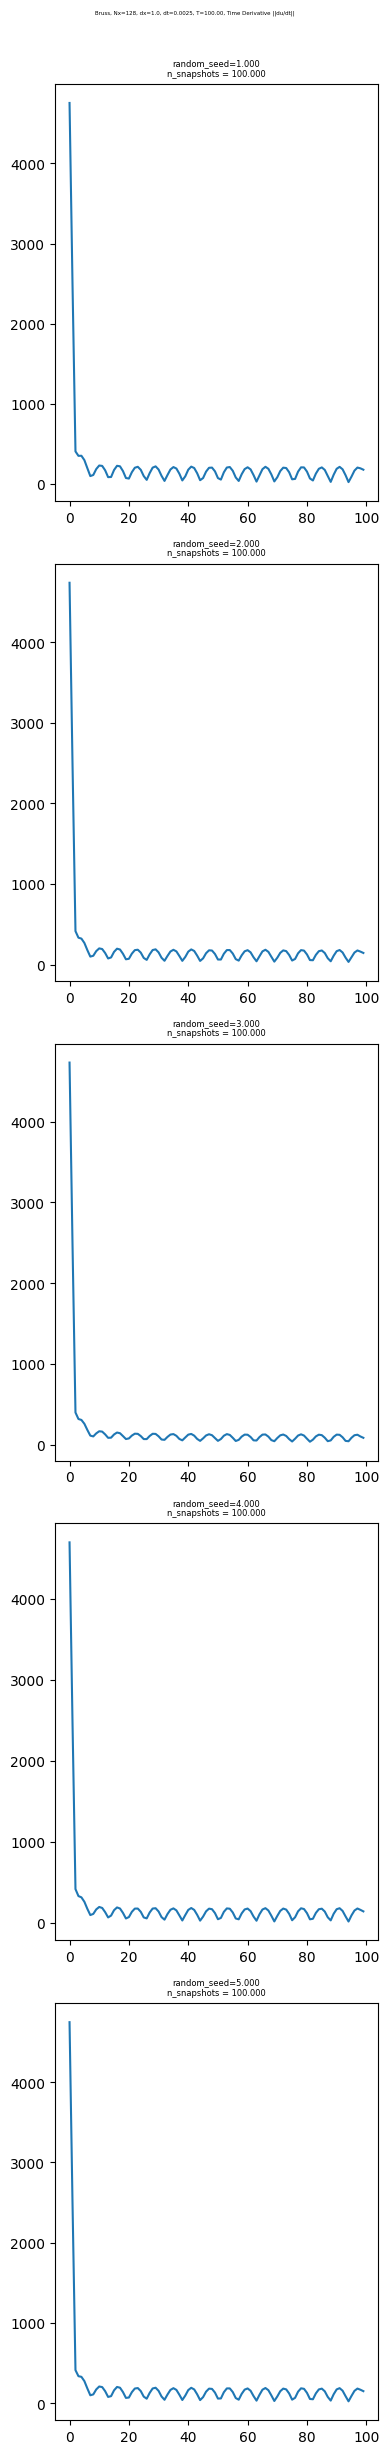

array([[<Axes: title={'center': 'random_seed=1.000\nn_snapshots = 100.000'}>,
        <Axes: title={'center': 'random_seed=2.000\nn_snapshots = 100.000'}>,
        <Axes: title={'center': 'random_seed=3.000\nn_snapshots = 100.000'}>,
        <Axes: title={'center': 'random_seed=4.000\nn_snapshots = 100.000'}>,
        <Axes: title={'center': 'random_seed=5.000\nn_snapshots = 100.000'}>]],
      dtype=object)

In [31]:
metrics_grid(df, 0, var1="random_seed", var2="n_snapshots", metric="dt")